<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis For Agritech Pest Prediction

## Model Implementation:
- ARIMA
- SARIMA
- ARIMAX
- SARIMAX

## **ARIMA**

In [1]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [2]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [56]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')
FeatureExtracted_df = pd.read_csv('/content/FeatureExtracted_dataset.csv')

In [57]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [58]:
# Display basic info for  datasets FeatureExtracted_dataset
print(FeatureExtracted_df.head(), '\n')
print(FeatureExtracted_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
0                13.91      13.6       14.4             97.65  ...   
1                20.78      20.1       21.2             83.49  ...   
2                19.03      18.7       19.5             96.87  ...   
3                15.33      15.0       15.7             82.29  ...   
4                15.48      15.0       16.0             87.12  ...   

   Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
0          30.6             72.25      

In [59]:
##---## Final_Merged_Dataset_Cleaned ##---##

# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# Sort dataset by 'Date'
Merged_Dataset_df = Merged_Dataset_df.sort_values(by='Date')

# Display the first few rows after conversion and sorting
print(Merged_Dataset_df.head())

         Date      Time  Number of Insects  New Catches  Event   Location  \
49 2024-07-05  11:31:01                0.0          0.0      0  Cicalino2   
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
50 2024-07-06  03:02:01                0.0          0.0      0  Cicalino2   
51 2024-07-07  03:04:01                0.0          0.0      0  Cicalino2   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   

    Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
49               16.690     16.30       17.0            89.480        27.140   
0                13.910     13.60       14.4            97.650        22.340   
50               19.135     18.75       19.4            86.480        27.295   
51               18.845     18.50       19.1            85.265        28.575   
1                20.780     20.10       21.2            83.490        23.520   

    Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_c

In [62]:
print(Merged_Dataset_df)

          Date      Time  Number of Insects  New Catches  Event   Location  \
49  2024-07-05  11:31:01                0.0          0.0      0  Cicalino2   
0   2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
50  2024-07-06  03:02:01                0.0          0.0      0  Cicalino2   
51  2024-07-07  03:04:01                0.0          0.0      0  Cicalino2   
1   2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
..         ...       ...                ...          ...    ...        ...   
145 2024-08-23  00:03:00                0.0          0.0      0     Imola2   
48  2024-08-23  06:03:00                0.0          0.0      0  Cicalino1   
97  2024-08-23  03:03:00                1.0          1.0      0  Cicalino2   
121 2024-08-23  00:04:00                5.0          1.0      0     Imola1   
152 2024-08-23  00:02:00                3.0          1.0      0     Imola3   

     Average Temperature  Temp_low  Temp_high  Average Humidity

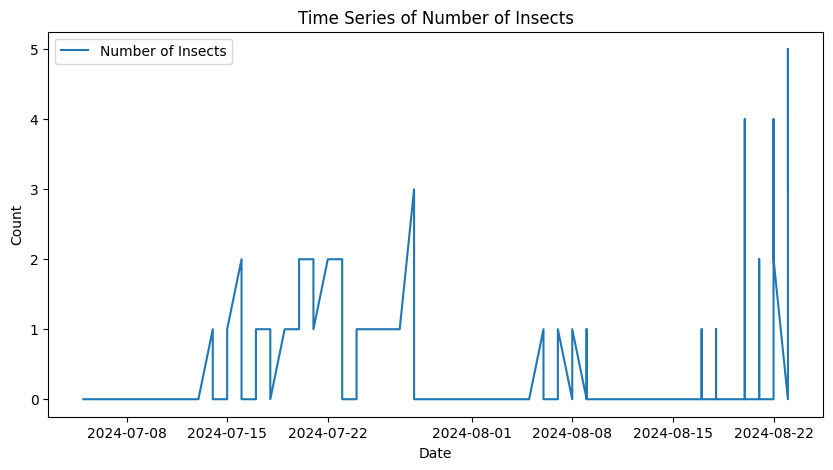

In [7]:
# set 'Date' column as index
Merged_Dataset_df.set_index('Date', inplace=True)

# Select the target variable for ARIMA
target_variable = 'Number of Insects'

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(Merged_Dataset_df[target_variable], label='Number of Insects')
plt.title('Time Series of Number of Insects')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [8]:
# Check for Stationarity using ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("\n--- ADF Test Results ---")
adf_test(Merged_Dataset_df[target_variable])


--- ADF Test Results ---
ADF Statistic: -0.8081696639782773
p-value: 0.8167105034754409
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is NOT stationary.


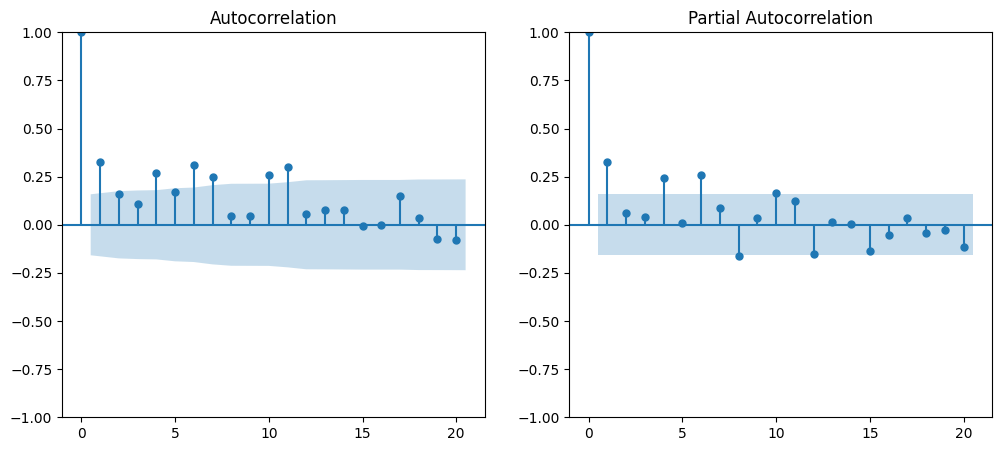

In [9]:
# Plot ACF and PACF to determine p and q without differencing
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(Merged_Dataset_df[target_variable], ax=ax[0], lags=20)
plot_pacf(Merged_Dataset_df[target_variable], ax=ax[1], lags=20)
plt.show()

In [10]:
# Differencing to handle non-stationary situation
df_diff = Merged_Dataset_df[target_variable].diff().dropna()

print("\n--- ADF Test Results ---")
adf_test(df_diff)


--- ADF Test Results ---
ADF Statistic: -4.590796450663175
p-value: 0.00013431018620596537
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is stationary.


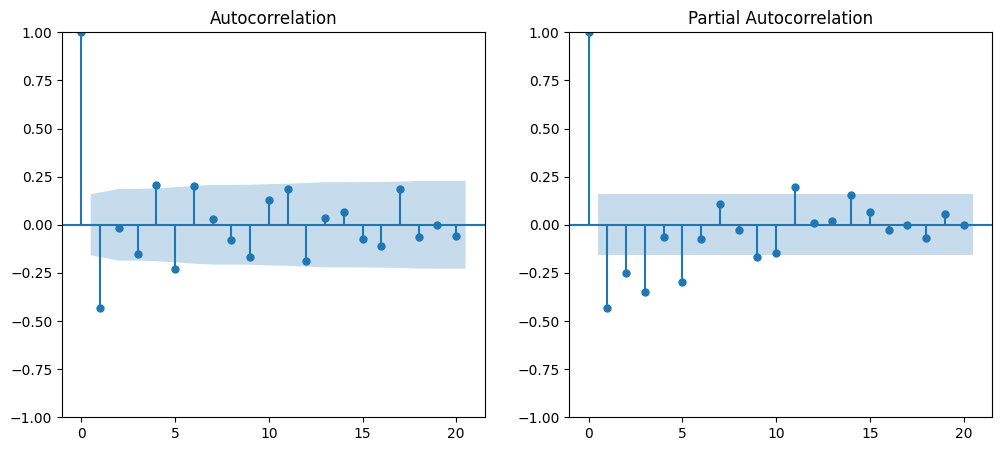

In [11]:
# Plot ACF and PACF to determine p and q with differencing (d=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_diff, ax=ax[0], lags=20)
plot_pacf(df_diff, ax=ax[1], lags=20)
plt.show()

In [12]:
# Use Auto-ARIMA to determine (p, d, q) automatically
model_auto = auto_arima(Merged_Dataset_df[target_variable], seasonal=False, trace=True, suppress_warnings=True, d=1)
print(model_auto.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=360.877, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=421.703, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=391.367, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=357.451, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=419.768, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=358.722, Time=1.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=358.593, Time=3.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=361.154, Time=1.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=356.531, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=357.782, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=357.650, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=389.609, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=360.242, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 10.772 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -176.266
Date:                Fri, 04 Apr 2025   AIC                            356.531
Time:                        15:40:04   BIC                            362.579
Sample:                             0   HQIC                           358.988
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8051      0.052    -15.463      0.000      -0.907 

In [13]:
# Fit ARIMA Model
p, d, q = model_auto.order
model = sm.tsa.ARIMA(Merged_Dataset_df[target_variable], order=(0, 1, 1))
model_fit = model.fit()

# Model Summary
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Number of Insects   No. Observations:                  153
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -176.266
Date:                Fri, 04 Apr 2025   AIC                            356.531
Time:                        15:40:05   BIC                            362.579
Sample:                             0   HQIC                           358.988
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8051      0.052    -15.463      0.000      -0.907      -0.703
sigma2         0.5913      0.026     22.504      0.000       0.540       0.643
Ljung-Box (L1) (Q):                   0.37   Jarque-

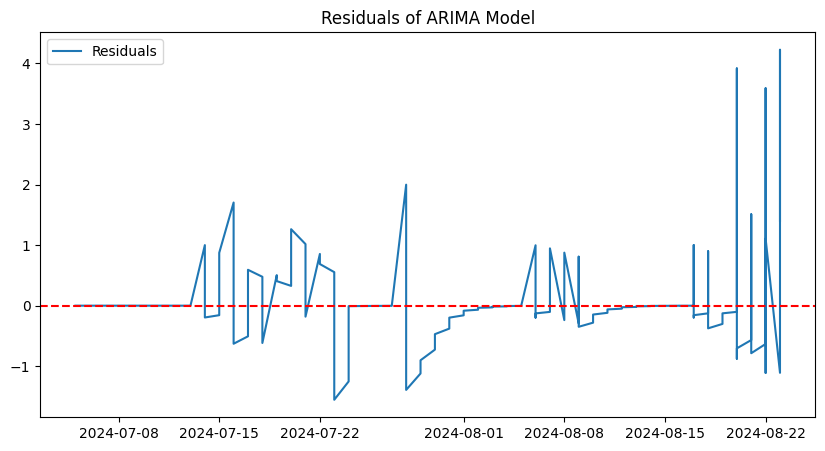

In [14]:
# Evaluate Model Performance - Residuals Analysis
plt.figure(figsize=(10, 5))
plt.plot(model_fit.resid, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


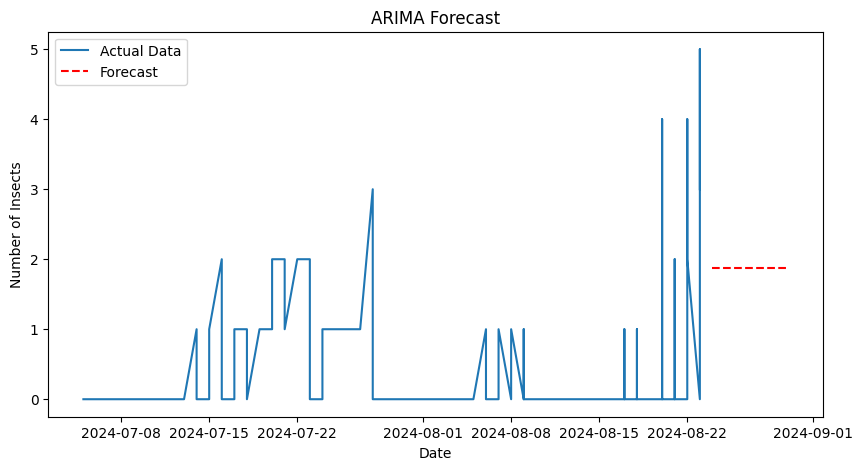

In [15]:
# Forecast Future Values
future_steps = 7  # Forecast for 30 days
forecast = model_fit.forecast(steps=future_steps)

# Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(Merged_Dataset_df[target_variable], label="Actual Data")
plt.plot(pd.date_range(start=Merged_Dataset_df.index[-1], periods=future_steps+1, freq='D')[1:],
         forecast, label="Forecast", linestyle='dashed', color='red')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.show()

In [16]:
##---## FeatureExtracted_dataset ##---##

# Convert 'Date' column to datetime format
FeatureExtracted_df['Date'] = pd.to_datetime(FeatureExtracted_df['Date'])

# Sort dataset by 'Date'
FeatureExtracted_df = FeatureExtracted_df.sort_values(by='Date')

# Display the first few rows after conversion and sorting
print(FeatureExtracted_df.head())

         Date      Time  Number of Insects  New Catches  Event   Location  \
49 2024-07-05  11:31:01                0.0          0.0      0  Cicalino2   
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
50 2024-07-06  03:02:01                0.0          0.0      0  Cicalino2   
51 2024-07-07  03:04:01                0.0          0.0      0  Cicalino2   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   

    Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
49               16.690     16.30       17.0            89.480  ...   
0                13.910     13.60       14.4            97.650  ...   
50               19.135     18.75       19.4            86.480  ...   
51               18.845     18.50       19.1            85.265  ...   
1                20.780     20.10       21.2            83.490  ...   

    Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
49         38.00            56.9

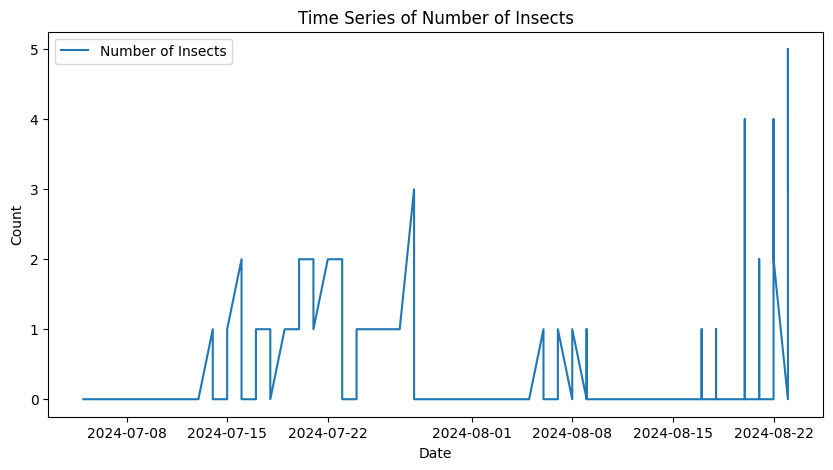

In [17]:
# set 'Date' column as index
FeatureExtracted_df.set_index('Date', inplace=True)

# Select the target variable for ARIMA
target_variable = 'Number of Insects'

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(FeatureExtracted_df[target_variable], label='Number of Insects')
plt.title('Time Series of Number of Insects')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [18]:
# Check for Stationarity using ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("\n--- ADF Test Results ---")
adf_test(FeatureExtracted_df[target_variable])


--- ADF Test Results ---
ADF Statistic: -0.8081696639782773
p-value: 0.8167105034754409
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is NOT stationary.


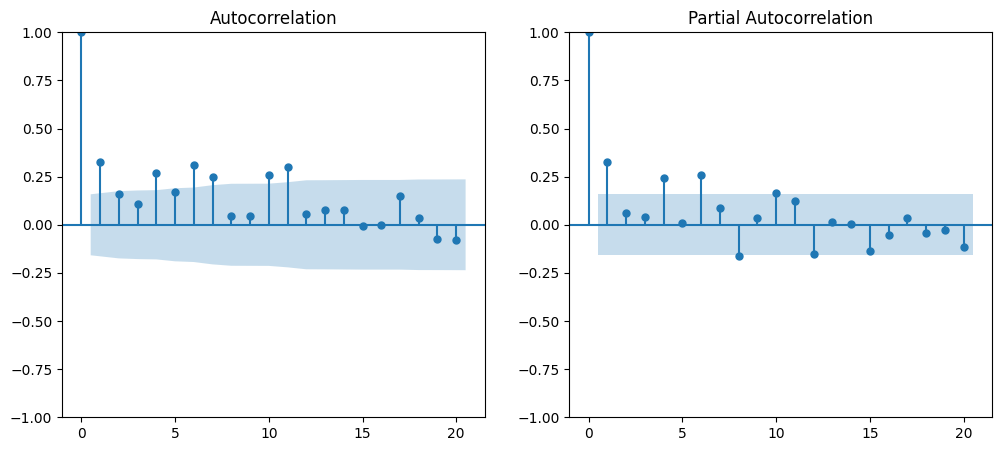

In [19]:
# Plot ACF and PACF to determine p and q without differencing
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(FeatureExtracted_df[target_variable], ax=ax[0], lags=20)
plot_pacf(FeatureExtracted_df[target_variable], ax=ax[1], lags=20)
plt.show()

In [20]:
# Differencing to handle non-stationary situation
df_diff = FeatureExtracted_df[target_variable].diff().dropna()

print("\n--- ADF Test Results ---")
adf_test(df_diff)


--- ADF Test Results ---
ADF Statistic: -4.590796450663175
p-value: 0.00013431018620596537
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
The series is stationary.


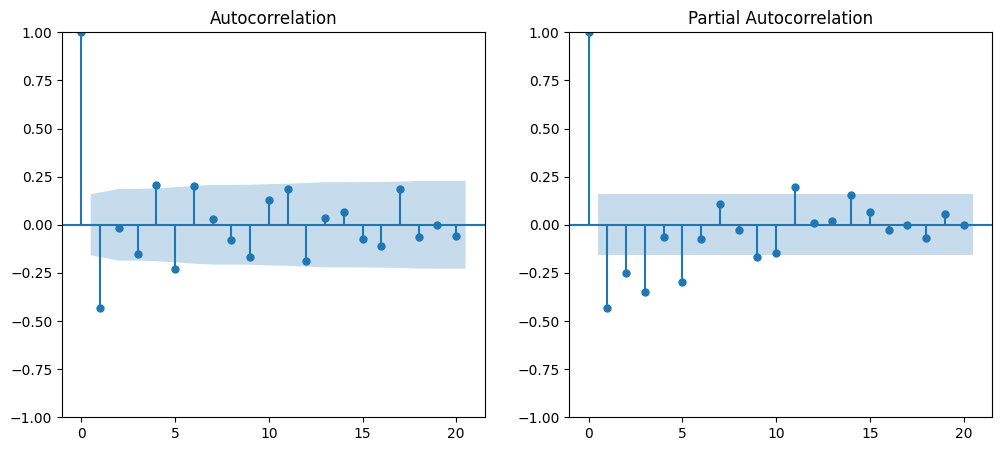

In [21]:
# Plot ACF and PACF to determine p and q with differencing (d=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_diff, ax=ax[0], lags=20)
plot_pacf(df_diff, ax=ax[1], lags=20)
plt.show()

In [22]:
# Use Auto-ARIMA to determine (p, d, q) automatically
model_auto = auto_arima(FeatureExtracted_df[target_variable], seasonal=False, trace=True, suppress_warnings=True, d=1)
print(model_auto.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=360.877, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=421.703, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=391.367, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=357.451, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=419.768, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=358.722, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=358.593, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=361.154, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=356.531, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=357.782, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=357.650, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=389.609, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=360.242, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.430 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -176.266
Date:                Fri, 04 Apr 2025   AIC                            356.531
Time:                        15:40:13   BIC                            362.579
Sample:                             0   HQIC                           358.988
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8051      0.052    -15.463      0.000      -0.907  

In [23]:
# Fit ARIMA Model
p, d, q = model_auto.order
model = sm.tsa.ARIMA(FeatureExtracted_df[target_variable], order=(0, 1, 1))
model_fit = model.fit()

# Model Summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Number of Insects   No. Observations:                  153
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -176.266
Date:                Fri, 04 Apr 2025   AIC                            356.531
Time:                        15:40:13   BIC                            362.579
Sample:                             0   HQIC                           358.988
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8051      0.052    -15.463      0.000      -0.907      -0.703
sigma2         0.5913      0.026     22.504      0.000       0.540       0.643
Ljung-Box (L1) (Q):                   0.37   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


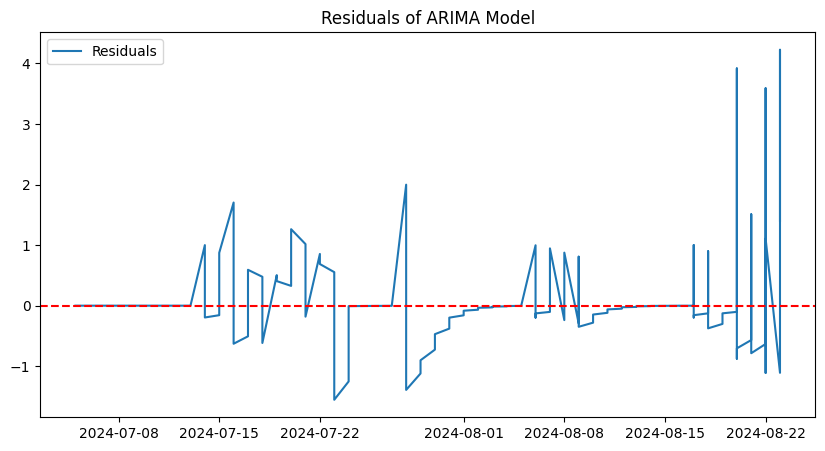

In [24]:
# Evaluate Model Performance - Residuals Analysis
plt.figure(figsize=(10, 5))
plt.plot(model_fit.resid, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


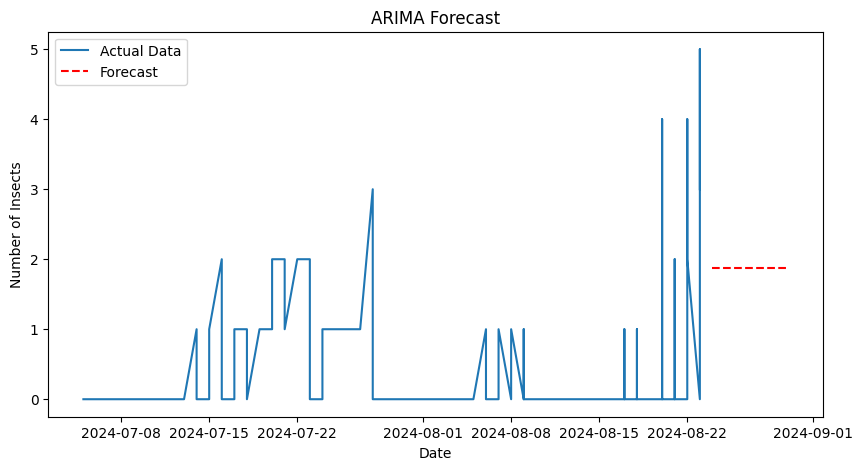

In [25]:
# Forecast Future Values
future_steps = 7  # Forecast for 30 days
forecast = model_fit.forecast(steps=future_steps)

# Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(FeatureExtracted_df[target_variable], label="Actual Data")
plt.plot(pd.date_range(start=FeatureExtracted_df.index[-1], periods=future_steps+1, freq='D')[1:],
         forecast, label="Forecast", linestyle='dashed', color='red')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.show()

## **ARIMAX**

In [45]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')

In [46]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [47]:
##---## Final_Merged_Dataset_Cleaned ##---##

# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# # Sort dataset by 'Date'
# Merged_Dataset_df = Merged_Dataset_df.sort_values(by='Date')

# Display the first few rows after conversion and sorting
print(Merged_Dataset_df.head())

# set 'Date' column as index
Merged_Dataset_df.set_index('Date', inplace=True)

        Date      Time  Number of Insects  New Catches  Event   Location  \
0 2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1 2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2 2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3 2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4 2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  
0    

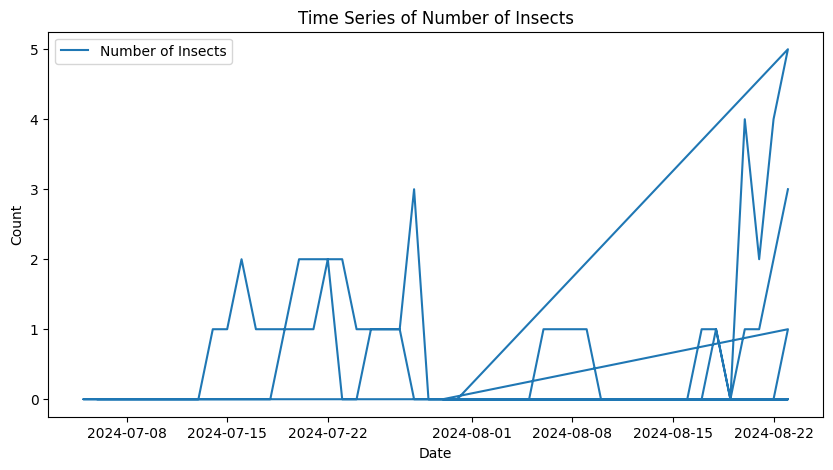

In [48]:
##---## Final_Merged_Dataset_Cleaned ##---##

# Select target variable
target_variable = 'Number of Insects'

# Select exogenous variables (external predictors)
exogenous_vars = ['Average Temperature', 'Temp_low', 'Temp_high', 'Average Humidity',
                  'Day Avg_temp', 'Day Min_temp', 'Day Max_temp', 'Day Avg_Humidity', 'Temp_change']

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(Merged_Dataset_df[target_variable], label='Number of Insects')
plt.title('Time Series of Number of Insects')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [49]:
# Check stationarity of the target variable
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("\n--- ADF Test Results for Target Variable ---")
adf_test(Merged_Dataset_df[target_variable])


--- ADF Test Results for Target Variable ---
ADF Statistic: -4.923970816198207
p-value: 3.131500430734416e-05
Critical Values: {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}
The series is stationary.


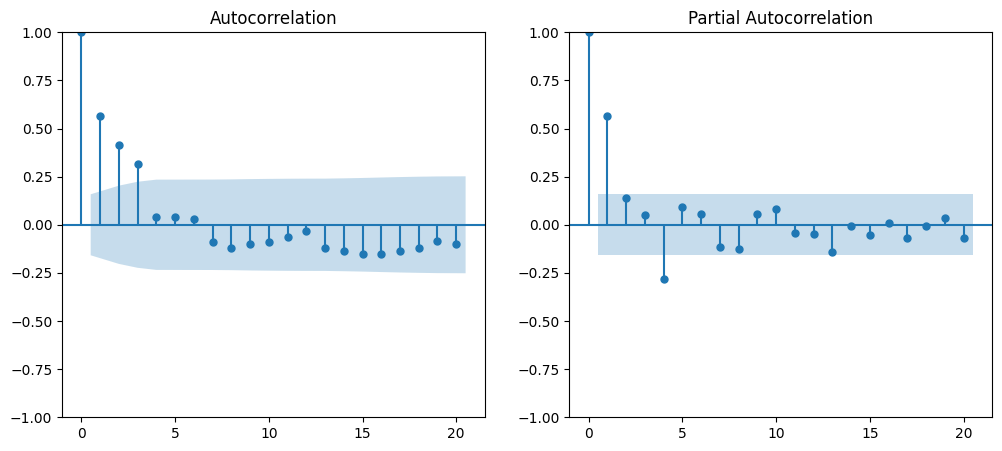

In [50]:
# Plot ACF and PACF to determine p and q without differencing
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(Merged_Dataset_df[target_variable], ax=ax[0], lags=20)
plot_pacf(Merged_Dataset_df[target_variable], ax=ax[1], lags=20)
plt.show()

In [51]:
# Use Auto-ARIMA to determine best (p, d, q) with exogenous variables
model_auto = auto_arima(Merged_Dataset_df[target_variable], exogenous=Merged_Dataset_df[exogenous_vars], seasonal=False, trace=True, suppress_warnings=True)
print(model_auto.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=327.928, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=413.607, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=328.987, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=359.115, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=325.373, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=353.144, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=325.607, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=314.212, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=312.280, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=314.208, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=305.260, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=339.100, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=307.127, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=307.098, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=321.350, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=309.050, Time=0.35 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 2.043 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -147.630
Date:                Fri, 04 Apr 2025   AIC                            305.260
Time:                        15:48:47   BIC                            320.412
Sample:                             0   HQIC                           311.415
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4133      0.154      2.689      0.007       0.112  

In [52]:
# Fit ARIMAX Model with identified parameters
p, d, q = model_auto.order
model = sm.tsa.ARIMA(Merged_Dataset_df[target_variable], exog=Merged_Dataset_df[exogenous_vars], order=(0, 0, 3))
model_fit = model.fit()

# Model Summary
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:      Number of Insects   No. Observations:                  153
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -137.913
Date:                Fri, 04 Apr 2025   AIC                            303.827
Time:                        15:49:42   BIC                            346.253
Sample:                             0   HQIC                           321.061
                                - 153                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.5290      2.141     -2.583      0.010      -9.725      -1.333
Average Temperature    -0.0815      0.636     -0.128      0.898      -1.328       1.165
Temp_low        

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


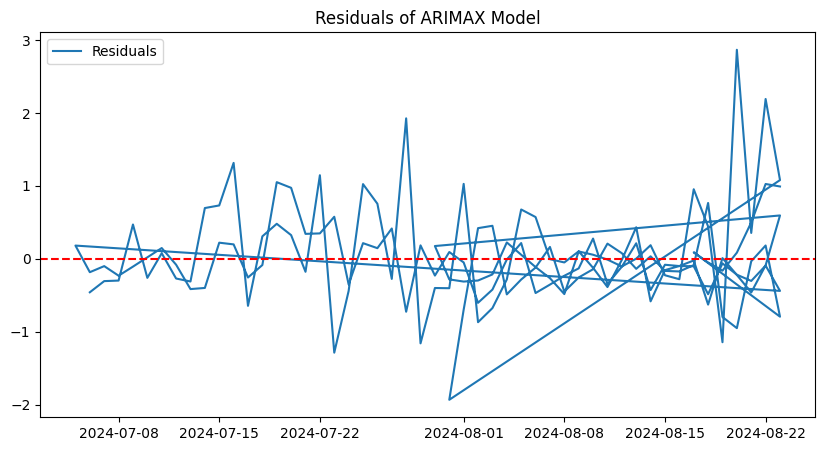

In [53]:
# Evaluate Model Performance - Residuals Analysis
plt.figure(figsize=(10, 5))
plt.plot(model_fit.resid, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of ARIMAX Model")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


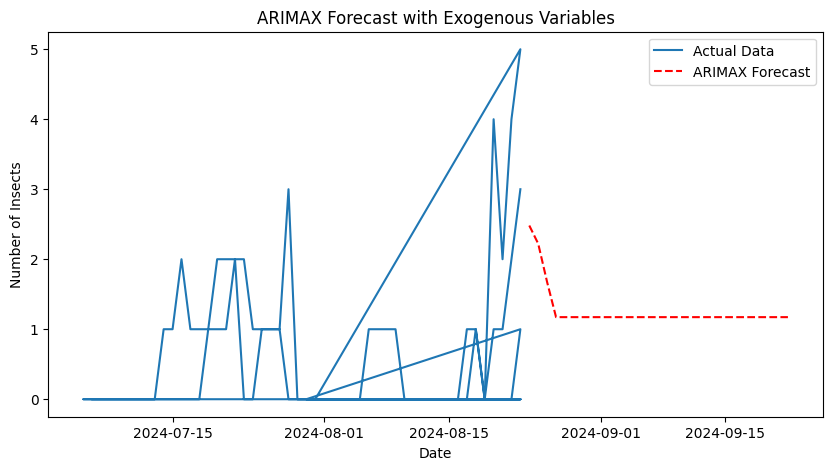

In [55]:
# Forecast Future Values with Exogenous Variables
future_steps = 30  # Forecast for 30 days

# Create future exogenous variable dataframe (assumption: using last observed values)
future_exog = pd.DataFrame(np.tile(Merged_Dataset_df[exogenous_vars].iloc[-1].values, (future_steps, 1)),
                           columns=exogenous_vars)

forecast = model_fit.forecast(steps=future_steps, exog=future_exog)

# Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(Merged_Dataset_df[target_variable], label="Actual Data")
plt.plot(pd.date_range(start=Merged_Dataset_df.index[-1], periods=future_steps+1, freq='D')[1:],
         forecast, label="ARIMAX Forecast", linestyle='dashed', color='red')
plt.title("ARIMAX Forecast with Exogenous Variables")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.show()